In [ ]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../')

from matplotlib.colors import LogNorm
from src.viz import plot_trajectories, use_mpl_scatter_density, plot_transition_matrix,plot_implied_timescales
from src.io import load_dataframe, save_dataframe
from src.preprocessing import (compute_phases,split_trajectories,filter_trajectories,smooth_trajectory_savgol)
from src.embedding import Embedding
from src.embedding_position import EmbeddingPosition
from umap import UMAP
from src.preprocessing import reconstruct_trajectory_from_angles

from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
df = pd.read_parquet('../data/toy_model/interim/phases.parquet')
print(df.shape)
df.head()

(99700, 9)


,x,y,z,label,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,0.651993,3.189867,3.388512,1,1,3.923019,0.110106,0.000000e+00,0.000000e+00
1,1.261468,5.076956,5.822094,1,2,2.268089,0.473653,0.000000e+00,0.000000e+00
2,1.818307,5.351280,7.073528,1,3,1.451915,1.618105,-1.490116e-08,1.490116e-08
3,2.319816,3.930307,7.082317,1,4,2.223421,0.378569,-0.000000e+00,0.000000e+00
4,2.778240,1.189198,6.123453,1,5,3.336075,0.075817,3.141593e+00,3.141593e+00


/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


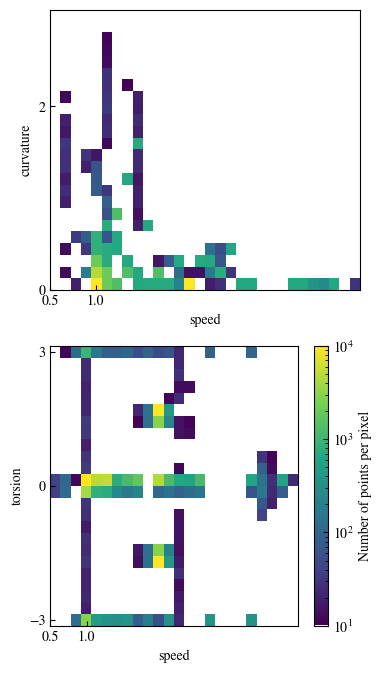

In [3]:
#plt.scatter(df[df['label'] ==1]['speed'],df[df['label'] ==1]['curvature_angle'],marker='o',alpha=0.1)
fig = plt.figure(figsize=(4,8))
norm = LogNorm(vmin=1e1,vmax=10**4)
ax1 = use_mpl_scatter_density(fig, df['speed'],df['curvature_angle'],dpi=10,norm=norm,nrows=2,pos=1,colorbar=None)
ax1.set_xlabel('speed')
ax1.set_ylabel('curvature')
ax1.set_xticks([0.5,1.])
ax1.set_yticks([0.,2.])
#ax1.grid()
ax2 = use_mpl_scatter_density(fig, df['speed'],df['torsion_angle'],dpi=10,norm=norm,nrows=2,pos=2)
ax2.set_xlabel('speed')
ax2.set_ylabel('torsion')
ax2.set_xticks([0.5,1])
ax2.set_yticks([-3,0,3])
#ax2.grid()
#fig.savefig('phase_space_toy_model.svg',transparent=True,bbox_inches='tight')

In [4]:
#emb = Embedding(df,
#                columns=['speed','curvature_angle','abs_torsion_angle'],
#                ID_NAME='label')
#emb = EmbeddingPosition(df,columns=['speed'],columns_translated=['x','y','z'],ID_NAME='label')
emb = EmbeddingPosition(df,columns=[],columns_translated=['x','y','z'],ID_NAME='label')
#emb = Embedding(df,
#                columns=['speed','curvature_angle'],ID_NAME='label')

In [5]:
emb.make_embedding(K=20)

(array([[[ 1.00470090e+01,  7.49596082e-01, -3.40199459e-16, ...,
          -9.99373643e+00, -8.70859135e-01, -6.69397519e-16],
         [ 1.14270339e+01, -2.17665286e+00, -6.40772906e-16, ...,
          -1.02681440e+01, -3.70805581e-01, -7.52758661e-17],
         [ 1.17140241e+01, -4.56120861e+00,  7.76587523e-16, ...,
          -1.01649620e+01,  2.19651778e-01,  1.84816627e-16],
         ...,
         [ 9.50006115e+00,  9.30105891e-03, -6.22325082e-15, ...,
          -9.50018495e+00,  1.70503204e-02, -3.02303838e-14],
         [ 9.50055770e+00, -7.59821129e-02,  2.32758608e-14, ...,
          -9.50033165e+00,  3.46534952e-02,  1.89880366e-14],
         [ 9.50077339e+00, -1.35273803e-01, -7.46352787e-15, ...,
          -9.50032024e+00,  4.24290980e-02,  3.59382657e-15]],
 
        [[-1.90000000e+01, -1.63155937e-15,  1.57305469e-18, ...,
           1.90000000e+01, -9.57829109e-16, -5.01012796e-18],
         [ 1.90000000e+01, -7.59348514e-16,  4.26322412e-16, ...,
          -1.90000000

In [6]:
emb.make_cluster(30,clustering_method='kmeans')#,n_subsample=1000)

array([11, 11,  6, ..., 29, 29, 29], dtype=int32)

In [7]:
# Label the rest by nearest center
from scipy.spatial.distance import cdist
dists = cdist(emb.flatten_embedding_matrix, emb.cluster_centers_, metric='euclidean')
emb.labels = np.argmin(dists, axis=1)
#self.cluster_centers_ = centers
#return self.labels

29
29


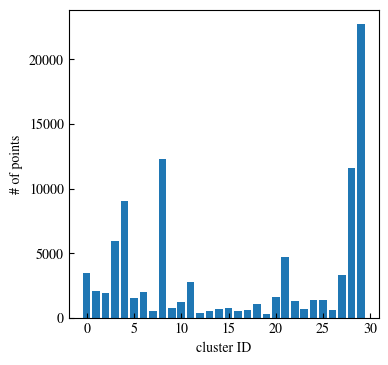

In [8]:
# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
# Optionally, zip into a dict
cluster_counts = dict(zip(unique_labels, counts))
fig,ax = plt.subplots(figsize=(4,4))
ax.bar(list(cluster_counts.keys()),list(cluster_counts.values()))
ax.set_xlabel('cluster ID')
ax.set_ylabel('# of points')
print(unique_labels[np.argmax(counts)])
print(np.argmax(counts))

In [9]:
rng = np.random.default_rng(10973)
print(emb.flatten_embedding_matrix.shape[0])
indices = rng.choice(emb.flatten_embedding_matrix.shape[0], size=9680, replace=False)
data = emb.flatten_embedding_matrix[indices]
    
combined =np.array([])
# Concatenate data and centers before UMAP
combined = np.append(data, emb.cluster_centers_, axis=0)

97800


In [10]:
reducer = UMAP(
        n_neighbors=10,
        min_dist=0.5,
        n_components=2,
        metric="euclidean",
    )
reduced_all = reducer.fit_transform(combined)

/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [11]:
N = data.shape[0]
reduced_points = reduced_all[:N]
reduced_centers = reduced_all[N:N + emb.cluster_centers_.shape[0]]

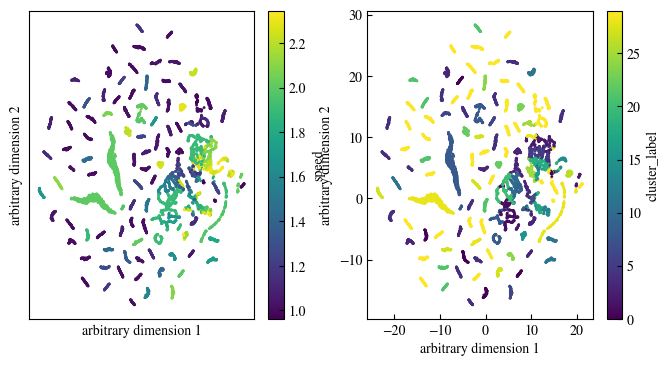

In [12]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))

speedx = emb.flatten_embedding_matrix[indices,0::3][:,1:] - emb.flatten_embedding_matrix[indices,0::3][:,:-1]
speedy = emb.flatten_embedding_matrix[indices,1::3][:,1:] - emb.flatten_embedding_matrix[indices,1::3][:,:-1]
speedz = emb.flatten_embedding_matrix[indices,2::3][:,1:] - emb.flatten_embedding_matrix[indices,2::3][:,:-1]
speed = np.mean(np.linalg.norm(np.array([speedx,speedy,speedz]).T,axis=2),axis=0)
color_values=speed
#color_values = np.mean(emb.flatten_embedding_matrix[indices, 0::4], axis=1)
sc = ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1,rasterized=True)
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
    
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
cbar = fig.colorbar(sc, ax=ax[0])
cbar.set_label(r'speed')
#cbar.ax.set_yticks([])  

color_values = np.mean(emb.flatten_embedding_matrix[indices, 1::3], axis=1)
color_values = emb.labels[indices]
sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1,rasterized=True)
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
#ax[1].set_xticks([])
#ax[1].set_yticks([])
ax[1].set_xlabel('arbitrary dimension 1')
ax[1].set_ylabel('arbitrary dimension 2')
cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label(r'cluster_label')
#cbar.ax.set_yticks([])  

#for i in range(2):
#    ax[i].set_xlim(-2,15)
#    ax[i].set_ylim(-2,10)

In [13]:
lambda_tau =[]
taus = np.array([1,2,3,4,5,10,15,20,25,30,40,50,100,200,300,500])
for tau in taus:
    emb.make_transition_matrix(tau=tau)
    eig_val,eig_vec = np.linalg.eig(emb.P.T)
    real_spectrum = np.abs(np.real(eig_val))
    # sort the eigen system according to the value of the real part
    eig_vec = eig_vec[:,np.argsort(real_spectrum)]#/np.sum(eig_vec[:,np.argsort(real_spectrum)],axis=1)
    real_spectrum = real_spectrum[np.argsort(real_spectrum)]
    lambda_tau.append(real_spectrum[-10:])
lambda_tau=np.array(lambda_tau)

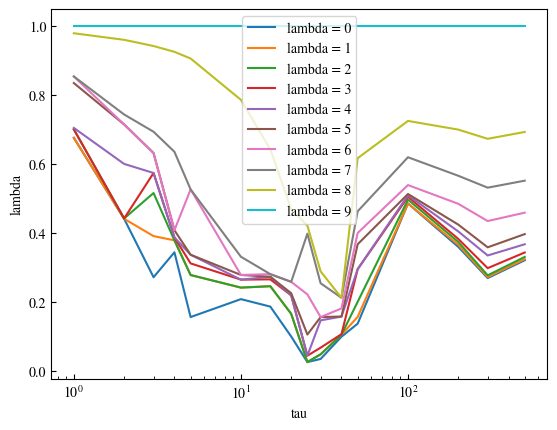

In [14]:
for i in range(min([10,eig_val.shape[0]])):
    plt.plot(taus,lambda_tau[:,i],label="lambda = "+str(i))
    plt.xscale('log')
plt.xlabel("tau")
plt.ylabel('lambda')
plt.legend()

emb.make_transition_matrix(tau=3)
val,vec = np.linalg.eig(emb.P.T)
vec = vec[:,np.argsort(val)]
print(val)

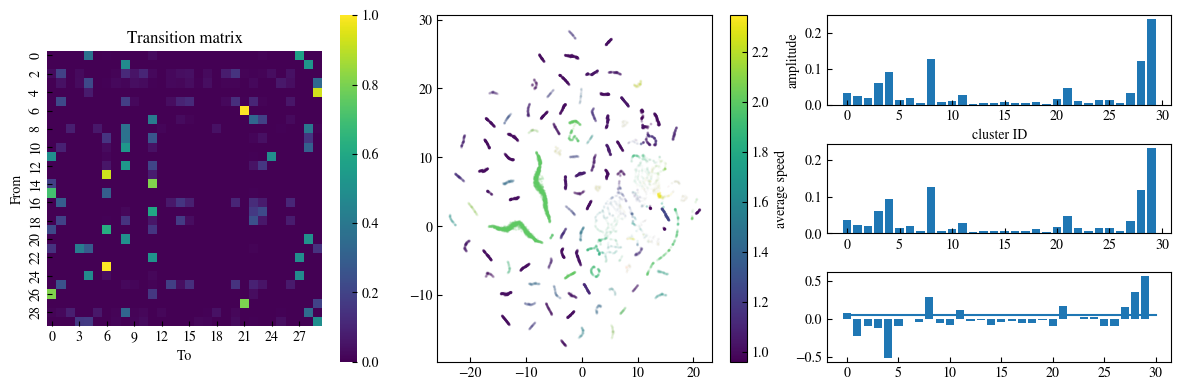

In [24]:
emb.make_transition_matrix(tau=10)
emb.reversibilized_matrix()

# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))
count_for_color = np.array(list(cluster_counts.values()))/np.sum(list(cluster_counts.values()))

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1,1], width_ratios=[1, 1, 1])
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[:,1])
ax02 = fig.add_subplot(gs[0,2])
ax12 = fig.add_subplot(gs[1,2])
ax22 = fig.add_subplot(gs[2,2])

val,vec = np.linalg.eig(emb.Pr.T)
vec = vec[:,np.argsort(val)]
val  = val[np.argsort(val)]
ss = np.abs(np.real(eig_vec[:,-1]))
ss = ss/np.sum(ss)


plot_transition_matrix(emb.P, ax=ax0)
plt.tight_layout()

color_values = speed#np.mean(emb.flatten_embedding_matrix[indices, 0::4], axis=1)
alpha = [count_for_color[lab] for lab in emb.labels[indices]]
sc = ax1.scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=alpha,rasterized=True,cmap='viridis')
cbar = fig.colorbar(sc, ax=ax1)
cbar.set_label('average speed')

ax02.bar(np.arange(0,ss.shape[0],1),ss)
ax02.set_xlabel('cluster ID')
ax02.set_ylabel('amplitude')


ax12.bar(list(cluster_counts.keys()),np.array(list(cluster_counts.values()))/np.sum(list(cluster_counts.values())))

slow = np.real(eig_vec[:,-2])
#slow = slow/np.sum(slow)
ax22.bar(np.arange(0,slow.shape[0],1),slow)
ax22.plot([0,30],[0.05,0.05])

plt.show()

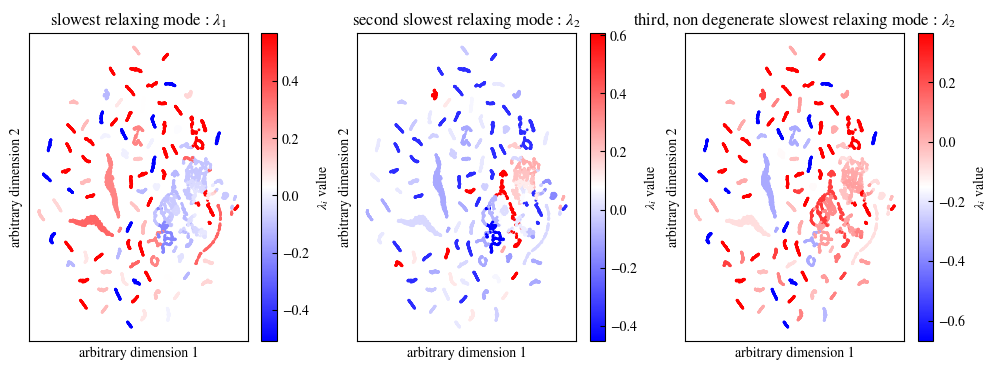

In [25]:
fig,ax = plt.subplots(ncols=3,figsize=(12,4))
slow_mode = (np.real(eig_vec[:,-2]))
color_values = [slow_mode[lab] for lab in emb.labels[indices]]
sc = ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
cbar = fig.colorbar(sc, ax=ax[0])
cbar.set_label(r'$\lambda_i$ value')

vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
ax[0].set_title(r'slowest relaxing mode : $\lambda_1$')

slow_mode = np.real(eig_vec[:,-3])
color_values = [slow_mode[lab] for lab in emb.labels[indices]]
sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('arbitrary dimension 1')
ax[1].set_ylabel('arbitrary dimension 2')
ax[1].set_title(r'second slowest relaxing mode : $\lambda_2$')

cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label(r'$\lambda_i$ value')
#ax.set_yticks([])  

slow_mode = np.real(eig_vec[:,-4])
color_values = [slow_mode[lab] for lab in emb.labels[indices]]
sc = ax[2].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('arbitrary dimension 1')
ax[2].set_ylabel('arbitrary dimension 2')
ax[2].set_title(r'third, non degenerate slowest relaxing mode : $\lambda_2$')

cbar = fig.colorbar(sc, ax=ax[2])
cbar.set_label(r'$\lambda_i$ value')

#cbar.ax.set_yticks([])  
#fig.savefig('umap_color_lambda.svg',transparent=True,bbox_inches='tight')

In [26]:
3/(1-val[:-1])

array([ 1.78359098,  1.89479313,  2.13866901,  2.37929639,  2.38608222,
        2.47822763,  2.52482231,  2.67257954,  2.76265217,  2.80851843,
        2.86962462,  2.91494335,  2.92752685,  2.95970824,  2.99373054,
        3.0219239 ,  3.04113013,  3.08591057,  3.11934543,  3.15011102,
        3.28669731,  3.29444725,  3.40671749,  3.58826   ,  4.0076267 ,
        4.65088207,  6.09426023,  9.56258511, 27.07571414])

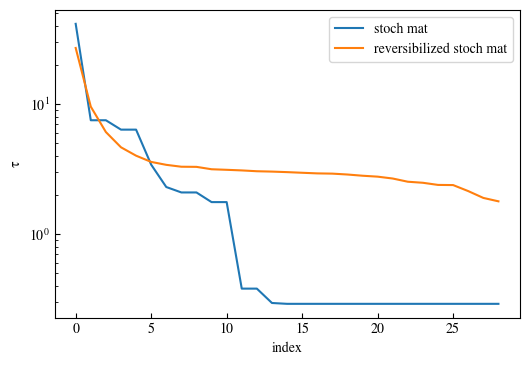

In [27]:
ts = emb.implied_timescales(tau=emb.tau)

ts_reversibilized = 3/(1-val[:-1][::-1])

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ts,label='stoch mat')
ax.plot(ts_reversibilized,label='reversibilized stoch mat')
plt.legend()
ax.set_ylabel("τ")
ax.set_xlabel("index")
plt.yscale('log')

emb.make_transition_matrix(tau=1)
state_trajectory = list()
emb.initialize_state()
state_trajectory.append(emb.state)
for i in range(5):
    emb.make_transition()
    state_trajectory.append(emb.state)
state_trajectory=np.array(state_trajectory)
print(state_trajectory.shape)

trajectory = list()
for points in state_trajectory:
    piece_of_trajectory = emb.pick_random_trajectory_in_cluster(points)
    trajectory.append(piece_of_trajectory)
trajectory = np.array(trajectory)
print(trajectory.shape)

XYZ = np.array([[0., 0., 0.]], dtype=float)
for traj in trajectory:
    # traj assumed to be flat array of length 3N
    coords = np.array([traj[0::3], traj[1::3], traj[2::3]])  # shape (3, N)
    coords = coords.T + XYZ[-1]  # shape (N, 3) + (3,) — this broadcasts correctly
    XYZ = np.vstack([XYZ, coords])
print(XYZ.shape)

fig,ax = plt.subplots(ncols=1,figsize=(8,4),subplot_kw={'projection':'3d'})
tint = trajectory.shape[1]//2 # phase_trajectory.shape[1] contains x and y
ax.plot(XYZ[:,0],XYZ[:,1],XYZ[:,2])#,marker='o')


In [28]:
df1 = pd.read_csv('../data/toy_model/interim/longest_trajectory.csv')
df1.head()
print(df1[['x','y','z']].to_numpy().shape)
print(emb.D)
#labels = emb.classify_trajectory(trajectory_trans=df1[['x','y','z']].to_numpy(),trajectory_abs=np.array([df1['speed'].to_numpy()]).T)
labels = emb.classify_trajectory(trajectory_trans=df1[['x','y','z']].to_numpy())

(997, 3)
3


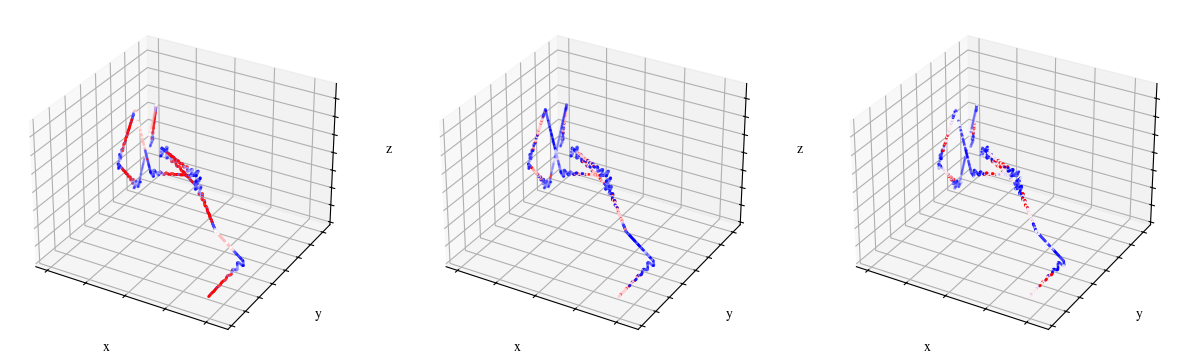

In [29]:
fig,ax = plt.subplots(ncols = 3, subplot_kw={'projection':'3d'},figsize=(15,5))

slow_mode = np.real(eig_vec[:,-2])
color_values = [abs(slow_mode[lab]) for lab in labels]
I = color_values.__len__()
ax[0].scatter(df1['x'][:I],df1['y'][:I],df1['z'][:I],c=color_values,cmap='bwr',s=1)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_zlabel('z')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_zticklabels([])
ax[0].grid(True)

slow_mode = np.real(eig_vec[:,-3])
color_values = [abs(slow_mode[lab]) for lab in labels]
I = color_values.__len__()
ax[1].scatter(df1['x'][:I],df1['y'][:I],df1['z'][:I],c=color_values,cmap='bwr',s=1.)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_zlabel('z')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_zticklabels([])
ax[1].grid(True)

slow_mode = np.real(eig_vec[:,-4])
color_values = [abs(slow_mode[lab]) for lab in labels]
I = color_values.__len__()
ax[2].scatter(df1['x'][:I],df1['y'][:I],df1['z'][:I],c=color_values,cmap='bwr',s=1.)
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_zlabel('z')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_zticklabels([])
ax[2].grid(True)


In [21]:
trajectory = df1[['x','y','z']].to_numpy()
L = trajectory.shape[0] - emb.K
embedded_trajectory = np.empty((L, emb.K * emb.D), dtype=float)
for t in range(L):
    embedded_trajectory[t] = emb.canonicalize_trajectory(trajectory[t:t + emb.K]).reshape(-1)

In [22]:
print(emb.n_clusters)

30


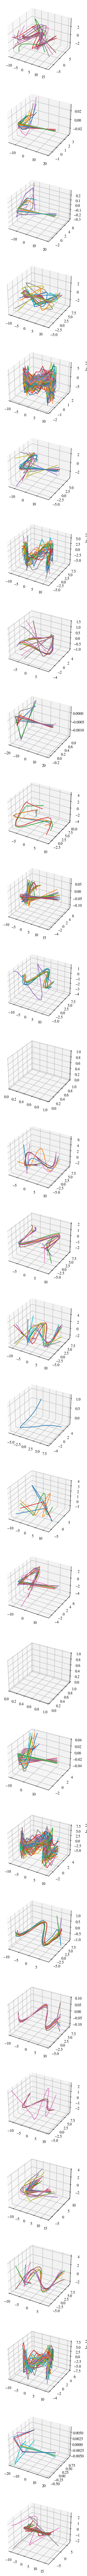

In [23]:
fig,ax = plt.subplots(nrows = emb.n_clusters,subplot_kw={'projection':'3d'},figsize=(4,4*emb.n_clusters))
for n,traj in enumerate(embedded_trajectory):
    ax[labels[n]].plot(traj[0::3],traj[1::3],traj[2::3])